In [1]:
import jax
import equinox as eqx
import optimistix as optx
import jax.numpy as np
import jax.util as jtu
import jax.random as jr
import matplotlib.pyplot as plt
import optax
from matplotlib import colormaps

jax.config.update("jax_enable_x64", True)

%matplotlib inline
plt.rcParams["image.cmap"] = "inferno"
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = "lower"
plt.rcParams["figure.dpi"] = 120

inferno = colormaps["inferno"]
seismic = colormaps["seismic"]

inferno.set_bad("k", 0.5)
seismic.set_bad("k", 0.5)

In [2]:
from amigo.files import get_files


def load_cal(file_path):
    files = get_files(
        [f"{file_path}/CAL04481/calslope/"],
        "calslope",
        IS_PSF=[True],  # Calibrators
        EXPOSURE=[str(i + 1) for i in range(1)],
        FILTER=["F380M", "F430M", "F480M"],
    )
    for file in files:
        file["BADPIX"].data[:, -1:] = 1
        file["BADPIX"].data[41:43, 1] = 1
        file["BADPIX"].data[58, 67] = 1
    return files

In [3]:
from amigo.model_fits import PointFit
from amigo.misc import populate_from_state
from amigo.core_models import initialise_model, Exposure
from amigo.ramp_models import build_pooled_layers, MinimalConv
from tqdm.notebook import tqdm

# Get files and nuke edges
files = load_cal("data/JWST")
outer = np.ones((80, 80)).at[4:-4, 4:-4].set(0.)
for file in files:
    fname = files[0][0].header["FILENAME"][:-18]
    if fname in file[0].header["FILENAME"]:
        file['BADPIX'].data[*np.where(outer)] = 1.

# Load the state
idx = 48
path = "/Users/louis/PhD/Software/sandbox/amigo_notebooks/bunya/results/calibrate"
config = np.load(f"{path}/configs/config_{idx}.npy", allow_pickle=True).item()
calib_state = np.load(f"{path}/calib/final_states/state_{idx}.npy", allow_pickle=True).item()

# Build the model
model, exposures = initialise_model(files, PointFit(), Teff_cache="../data/Teffs")
ramp = MinimalConv(*build_pooled_layers(config["width"], config["depth"]))
model = populate_from_state(model.set("ramp", ramp), calib_state)

/Users/louis/mambaforge/envs/dx_test/lib/python3.12/site-packages/amigo/ramp_models.py:327: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  eqx.nn.Conv2d(
/Users/louis/mambaforge/envs/dx_test/lib/python3.12/site-packages/amigo/ramp_models.py:327: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  eqx.nn.Conv2d(
/Users/louis/mambaforge/envs/dx_test/lib/python3.12/site-packages/amigo/ramp_models.py:327: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  eqx.nn.Conv2d(
/Users/louis/mambaforge/envs/dx_test/lib/python3.12/site-packages/amigo/ramp_models.py:327: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  eqx.nn.Conv2d(
/Users/louis/mambaforge/envs/dx_test/lib/python3.12/site-packages/amigo/ramp_models.

In [4]:
# New exposure to hold the illuminance
class NewExposure(Exposure):
    illuminance: np.ndarray = None

    def __init__(self, *args, illuminance=None, **kwargs):
        self.illuminance = illuminance
        super().__init__(*args, **kwargs)

# Get the new exposures to hold illuminance
_exposures = []
for exp in tqdm(exposures):

    # Get the illuminance
    flux = 10 ** model.get(exp.map_param("fluxes"))
    psf = exp.fit.model_psf(model, exp)
    psf = exp.fit.model_detector(psf, model, exp).data
    illuminance = flux * psf

    # Get the new exposure
    outer = np.ones_like(exp.badpix).at[4:-4, 4:-4].set(0.)
    for file in files:
        fname = files[0][0].header["FILENAME"][:-18]
        if fname in file[0].header["FILENAME"]:
            file['BADPIX'].data[*np.where(outer)] = 1.

            exp = NewExposure(file, PointFit(), illuminance=illuminance)

    # Badpix quick-fix
    slopes = exp.slopes.at[:, *np.where(exp.badpix)].set(0)
    var = exp.variance.at[:, *np.where(exp.badpix)].set(1.)
    exp = exp.set(["slopes", "variance"], [slopes, var])
    _exposures.append(exp)
exposures = _exposures

  0%|          | 0/3 [00:00<?, ?it/s]

/Users/louis/mambaforge/envs/dx_test/lib/python3.12/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=bool with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/Users/louis/mambaforge/envs/dx_test/lib/python3.12/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=bool with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


In [5]:
from jax import grad, vmap
from amigo.ode_models import Polynomial, ODEFunc, ODERamp
from amigo.misc import calc_laplacian
from amigo.ramp_models import Ramp


class PolynomialODE(ODEFunc):
    gain_fn: Polynomial
    bleed_fn: Polynomial

    def __init__(self, gains_start=1, gain_order=4, bleed_start=1, bleed_order=4):
        self.gain_fn = Polynomial(gains_start, gain_order)
        self.bleed_fn = Polynomial(bleed_start, bleed_order)

    def __getattr__(self, name):
        if hasattr(self.gain_fn, name):
            return getattr(self.gain_fn, name)
        if hasattr(self.bleed_fn, name):
            return getattr(self.bleed_fn, name)
        raise AttributeError(f"ODESolver.ODE has no attribute {name}")

    def dgain_dt(self, t, illuminance):
        """Gain polynmial derivative with respect to time.
        We leverage autodiff to compute the derivative of the gain polynomial"""
        grad_fn = grad(lambda t, x: self.gain_fn.evaluate(t * x))
        grad_fn_vmap = vmap(lambda t, x: grad_fn(t, x), (None, 0))
        grad_fn_2d = lambda t, arr: grad_fn_vmap(t, arr.flatten()).reshape(arr.shape)
        return grad_fn_2d(t, illuminance)

    def dbleed_dt(self, charge):
        return self.bleed_fn.evaluate_arr(calc_laplacian(charge))

    def derivative(self, t, charge, illuminance):
        dqdt = illuminance
        dqdt += self.dgain_dt(t, illuminance)
        dqdt += self.dbleed_dt(charge)
        return dqdt


def loglike_residual(ode_model, model, exposure):
    """Normalised normal log likelihood per pixel"""
    ramp = ode_model.predict_ramp(exp.illuminance, exp.ngroups)
    pred_slopes = exp.fit.model_read(Ramp(ramp, 1.0), model, exp)
    pred_vec = exp.to_vec(pred_slopes)
    data_vec = exp.to_vec(exp.slopes)
    err_vec = exp.to_vec(exp.variance**0.5)
    return (data_vec - pred_vec) / (err_vec * ode_model.norm)


@eqx.filter_jit
@eqx.debug.assert_max_traces(max_traces=1)
def residual_fn(ode_model, args):
    model, exposures = args
    return np.concatenate(
        [loglike_residual(ode_model, model, exp).flatten() for exp in exposures]
    )


# Define the ODE model
ODE = PolynomialODE()
ode_model = ODERamp(ODE, oversample=1)

# input args
args = (model, exposures)
print_vals = {"step", "accepted", "loss", "step_size"}
solver = optx.LevenbergMarquardt(rtol=1e-6, atol=1e-6, verbose=frozenset(print_vals))
sol = optx.least_squares(residual_fn, solver, ode_model, args=args)

trained_ode = sol.value
print(trained_ode)
print(trained_ode.gain_fn.coeffs, trained_ode.bleed_fn.coeffs)
print(optx.RESULTS[sol.result])
# print(residual_fn(ode_model, args))
# print(residual_fn(trained_ode, args))

Step: 0, Accepted steps: 0, Steps since acceptance: 0, Loss on this step: 0.2051445898730503, Loss on the last accepted step: 0.0, Step size: 1.0
Step: 1, Accepted steps: 1, Steps since acceptance: 0, Loss on this step: 0.1795406614129229, Loss on the last accepted step: 0.2051445898730503, Step size: 1.0
Step: 2, Accepted steps: 2, Steps since acceptance: 0, Loss on this step: 0.1744087667686299, Loss on the last accepted step: 0.1795406614129229, Step size: 1.0
Step: 3, Accepted steps: 3, Steps since acceptance: 0, Loss on this step: 0.17244554779267596, Loss on the last accepted step: 0.1744087667686299, Step size: 1.0
Step: 4, Accepted steps: 4, Steps since acceptance: 0, Loss on this step: 0.17144101588462057, Loss on the last accepted step: 0.17244554779267596, Step size: 1.0
Step: 5, Accepted steps: 5, Steps since acceptance: 0, Loss on this step: 0.17085089123261488, Loss on the last accepted step: 0.17144101588462057, Step size: 1.0
Step: 6, Accepted steps: 6, Steps since acce

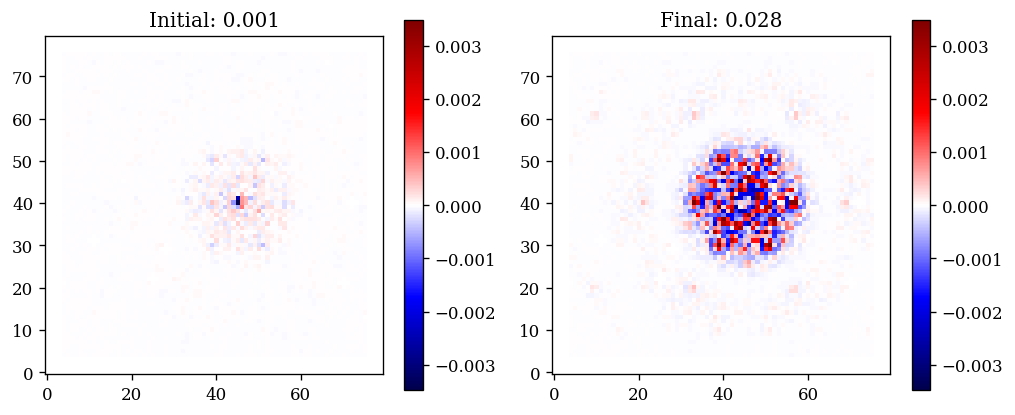

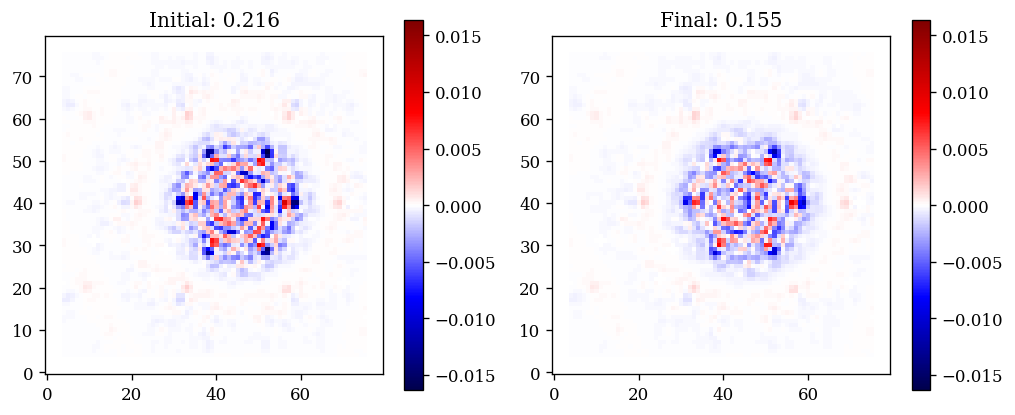

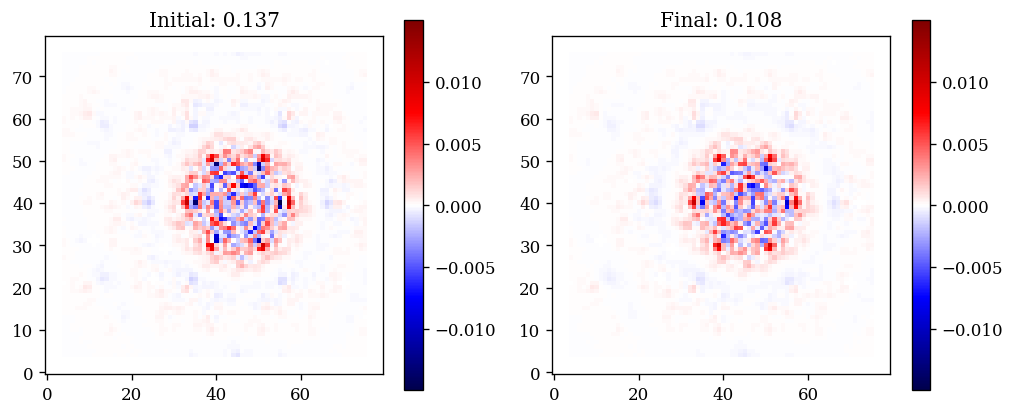

In [6]:
for exp in exposures:
    init_resid_vec = loglike_residual(ode_model, model, exp)
    final_resid_vec = loglike_residual(trained_ode, model, exp)

    init_resid = vmap(exp.from_vec)(init_resid_vec.T)
    final_resid = vmap(exp.from_vec)(final_resid_vec.T)

    v = np.nanmax(np.abs(np.mean(init_resid, 0)))
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.title(f"Initial: {np.nansum(init_resid**2):.3f}")
    plt.imshow(np.mean(init_resid, 0), "seismic", vmin=-v, vmax=v)
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.title(f"Final: {np.nansum(final_resid**2):.3f}")
    plt.imshow(np.mean(final_resid, 0), "seismic", vmin=-v, vmax=v)
    plt.colorbar()
    plt.show()

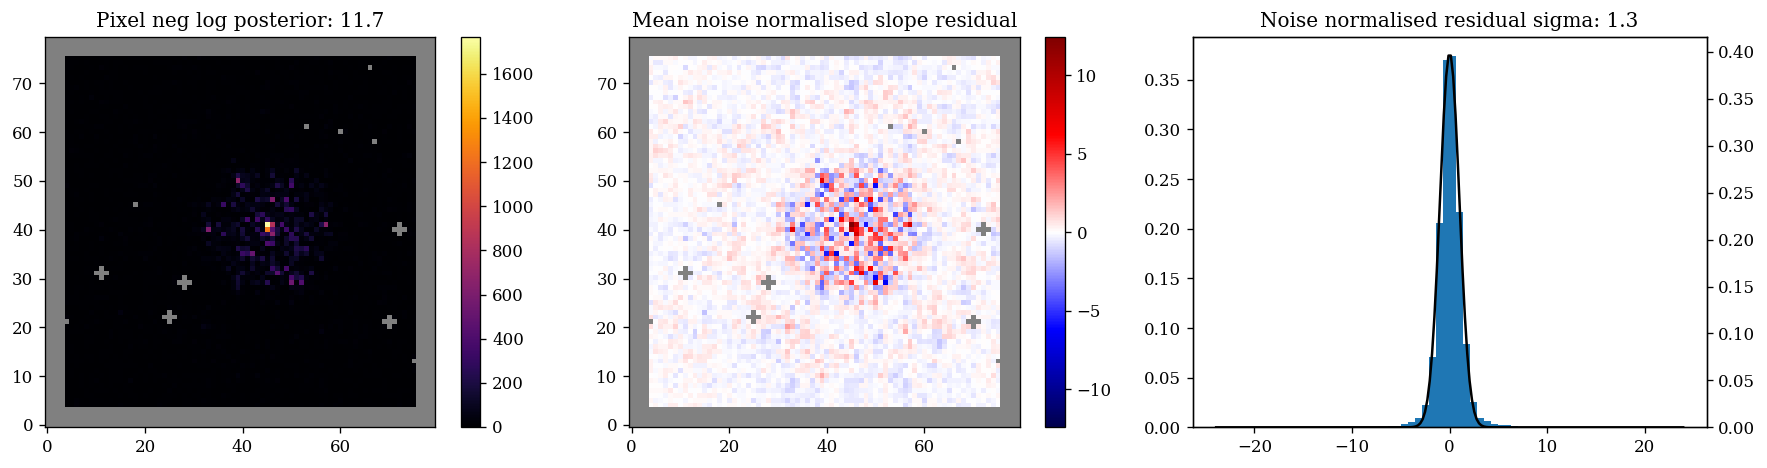

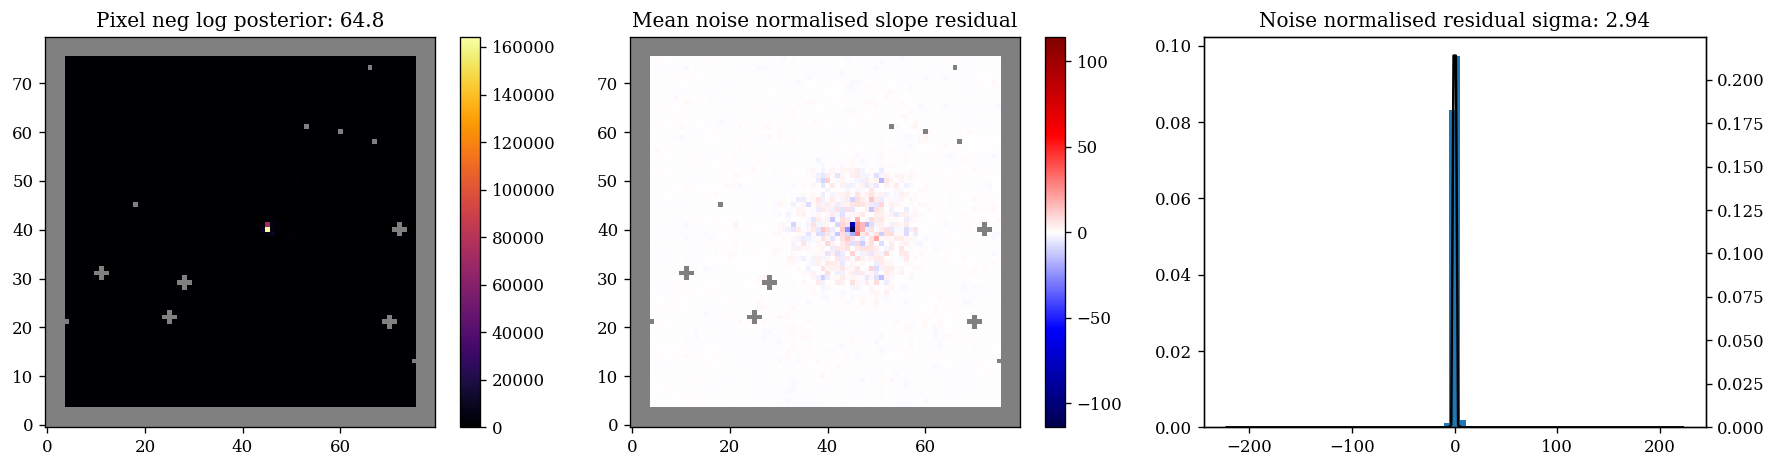

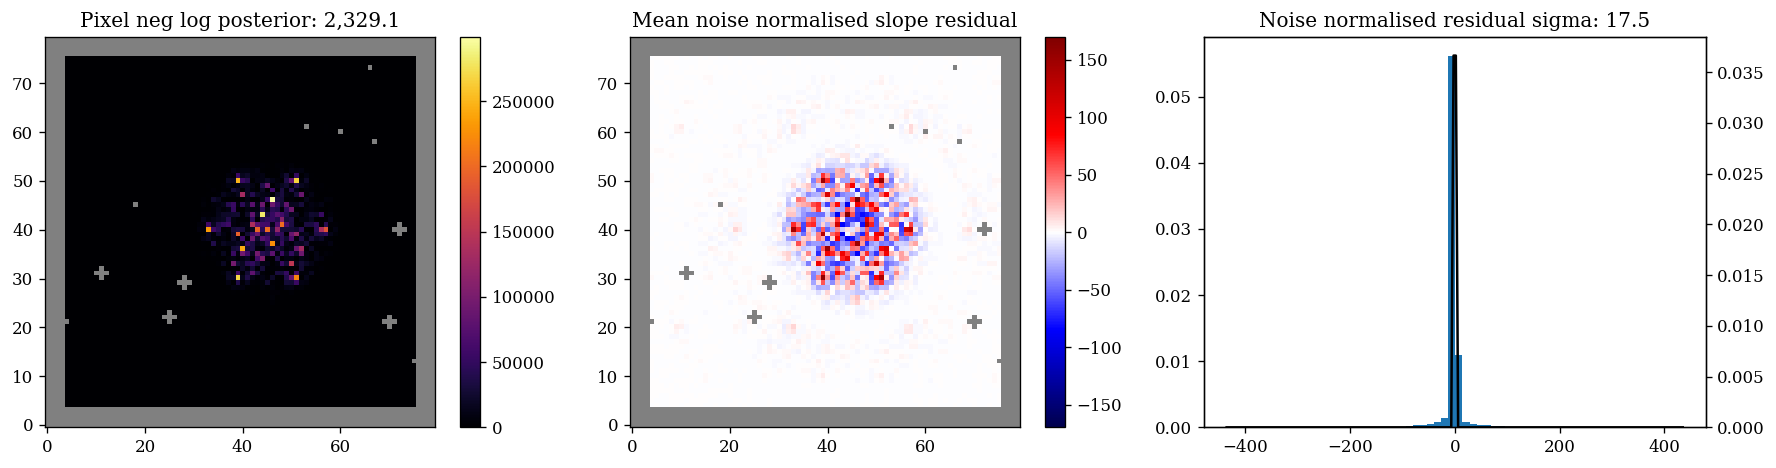

In [7]:
from amigo.plotting import summarise_fit

exp = exposures[0]
summarise_fit(exp, model)
summarise_fit(exp, model.set("ramp", None))
summarise_fit(exp, model.set("ramp", trained_ode))